<a href="https://colab.research.google.com/github/ZinnurovArtur/Colour-Match/blob/main/color_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np 
import requests
import cv2
from collections import Counter
from tensorflow.keras.models import load_model


from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import tensorflow as tf
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
from skimage.color import rgb2lab,deltaE_cie76

import os
%matplotlib inline


In [ ]:
from google.colab import drive
from keras.datasets import fashion_mnist

drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


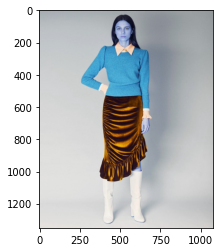

In [ ]:
image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/datasets/pictures_outfit/bauman/bauman-yeallow.jpg')

plt.imshow(image)

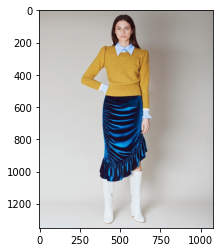

In [ ]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)



In [ ]:
#Rgb to hext conversion
def rgbTohex(color):
  return "#{:02x}{:02x}{:02x}".format(int(color[0]),int(color[1]), int(color[2]))

In [ ]:
def get_image(image_path):
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  return image

In [ ]:
def get_colors(image,numCol, chart):
  clf = KMeans(n_clusters= numCol)
  new_image = cv2.resize(image,(600,400),interpolation = cv2.INTER_AREA)
  new_image = new_image.reshape(new_image.shape[0]*new_image.shape[1],3)

  labels = clf.fit_predict(new_image)
  counts = Counter(labels)
  counts = dict(sorted(counts.items()))

  center_colors = clf.cluster_centers_
  ordered_colors = [center_colors[i] for i in counts.keys()]
  hex_colors = [rgbTohex(ordered_colors[i]) for i in counts.keys()]
  rgb_colors = [ordered_colors[i] for i in counts.keys()]

  
  sorted_values = sorted(counts.items(), key = lambda x:x[1], reverse=True)
  sorted_keys = [sorted_values[i][0] for i in range(len(sorted_values))]

  sorted_rgb = [center_colors[i] for i in sorted_keys]
  print(sorted_rgb)



  if(chart):
    plt.figure(figsize = (5,5))
    plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)
  
  return sorted_rgb




[array([218.09333422, 219.40599186, 219.87502502]), array([200.76855692, 199.02682676, 196.39063555]), array([178.09167786, 173.87147393, 168.01819514]), array([159.26187611, 150.46114137, 143.25760071]), array([198.94798235, 154.02875158,  63.50138714]), array([27.56287106, 21.69721419, 42.23839245]), array([ 13.54738646,  54.53470437, 104.71156812]), array([ 20.72599023, 117.24959305, 185.19831796])]


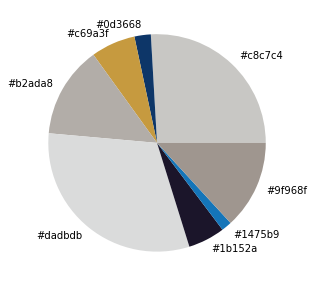

In [ ]:
arr_ofrgb = get_colors(get_image('/content/drive/MyDrive/Colab Notebooks/datasets/pictures_outfit/bauman/bauman-yeallow.jpg'),8,True)

In [ ]:
#Image segmentation 
def get_cloth(filename,stacked=False):
  file1 = cv2.imread(filename)
  file1 = tf.image.resize_with_pad(file1,target_height = 512, target_width = 512)
  rgb = file1.numpy()
  file1 = np.expand_dims(file1,axis=0)/255.
  seq = load_model("/content/drive/MyDrive/Colab Notebooks/datasets/save_ckp_frozen.h5").predict(file1)
  seq = seq[3][0,:,:,0]
  seq = np.expand_dims(seq,axis=-1)
  c1x = rgb*seq
  c2x =rgb*(1-seq)
  cfx = c1x+c2x
  dummcol = np.ones((rgb.shape[0],rgb.shape[1],1))
  rgbx = np.concatenate((rgb,dummcol*255),axis=-1)
  rgbs = np.concatenate((cfx,seq*255),axis =-1)
  if stacked:
    stacked = np.hstack((rgbx,rgbs))
    return stacked
  else:
    return rgbs


In [ ]:
import matplotlib.patches as patches
def generate_patches(rgb):
  colors = []
  for i in range(5):
    colors.append([rgbTohex(rgb[i])])

  

  categories = ["color 1", "color 2", "color 3", "color 4", "color 5"]
  legend_dict = dict(zip(categories,colors))
  patchesM = []
  for key in legend_dict:
    data_key = patches.Patch(facecolor=legend_dict[key][0],edgecolor=None,label=key)
    patchesM.append(data_key)

  plt.gca()
  plt.legend(handles=patchesM,ncol=len(categories), fontsize='small')
  plt.show()

In [ ]:
def takeperson(img):
    img = cv2.imread(img,cv2.IMREAD_UNCHANGED)
    img = cv2.resize(img,(512,512))
    mask = np.zeros(img.shape[:2],np.uint8)
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    height, width = img.shape[:2]
    rect = (50,10,width-100,height-20)
    cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,
               cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    img2 = img*mask2[:,:,np.newaxis]
    img2[mask2 == 0] = (255, 255, 255)
    
    final = np.ones(img.shape,np.uint8)*0 + img2
    rgb = cv2.cvtColor(final,cv2.COLOR_BGRA2BGR)
    cv2.imwrite("noback.png",rgb)
   
  
    return mask, rgb

In [ ]:
def removeAlpha(im):
  image = cv2.imread(im,cv2.IMREAD_UNCHANGED)
  trans_mask = image[:,:,3] <= 162 # the ml background
  image[trans_mask] = [255,255,255,255]
  new_img = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
  return cv2.imwrite("new.png",new_img)

In [ ]:
import json
def query(color):


  data = {'model':"default",'input':[color[0],color[1],color[2],color[3],color[4]]}
  data = json.dumps(data)

  response = requests.post('http://colormind.io/api/', data=data)
  return response

In [ ]:
from PIL import Image 



def converterHUE(b,g,r,sat):
  # convert bgr colour to hsv
  color = np.uint8([[[b,g,r]]])
  hsv=cv2.cvtColor(color,cv2.COLOR_BGR2HSV)
  hue = hsv[0][0][0]
  print(hsv[:,:,1].mean())
  print(hsv[0][0][0],hsv[0][0][1],hsv[0][0][2])
  #Thresholding the image on lover and darker version of colour
  low = [hue-sat,hsv[0][0][1]-sat,hsv[0][0][2]-sat]
  up = [hue+sat,255,255]
  return low,up


def changeColor(image,input_color,target_color,sat):
  im = cv2.imread(image)
  hsv=cv2.cvtColor(im,cv2.COLOR_BGR2HSV)
 
  for i in range(len(input_color)):
    low,up = converterHUE(input_color[i][2], input_color[i][1], input_color[i][0],sat)
    colr_lo = np.array(low)
    colr_hi = np.array(up)
    # normilise values and mask image from lover range to hi range
    mask = cv2.inRange(hsv, colr_lo,colr_hi)
    print(target_color[i][2])
    #add new values of certain colour
    im[mask>0] = (target_color[i][2], target_color[i][1],
                  target_color[i][0])
  cv2.imwrite("result.png",im)
  plt.imshow(mask)



def adding_toanother(first,second):
  img1 = cv2.imread(first)
  img1 = cv2.resize(img1,(512,512))
  img2 = cv2.imread(second)
  added_image = cv2.addWeighted(img1,0.6,img2,0.6,0)
  cv2.imwrite("result2.png",added_image)
  


In [ ]:
def remove_bk(image):
  img = Image.open(image)
  img = img.convert("RGBA")
  datas = img.getdata()

  arr = []
  for item in datas:
    if item[0] == 255 and item[1] == 255 and item[2] == 255:
      arr.append((255,255,255,0))
    else:
        arr.append(item)
        #print(item)
  img.putdata(arr)
  img.save("result.png","PNG")


In [ ]:

def combine(inImg,outImg):
  img1 = Image.open(inImg)
  img1.thumbnail((512,512),Image.ANTIALIAS)
  img2 = Image.open(outImg)
  img2.thumbnail((512,512),Image.ANTIALIAS)
  back = img1.copy()
  back.paste(img2, (-50, 0), img2)
  back.save("out2.png",quility =95)
  plt.imshow(back)

[array([254.99193978, 254.98698184, 254.98380819]), array([173.98058252, 110.69711473,  72.80869684]), array([186.17096059, 134.96553489,  97.45879543]), array([200.67311988, 157.39017126, 119.45923306]), array([216.34972914, 179.05807151, 143.27107259]), array([142.11309524,  79.65059524,  55.51845238]), array([111.52655414,  40.28653767,  33.34664471]), array([230.66213152, 210.2324263 , 200.09750567])]
[173.98058252 110.69711473  72.80869684]


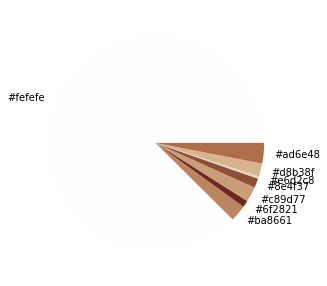

In [ ]:
from PIL import Image


path_img = "/content/drive/MyDrive/Colab Notebooks/datasets/pictures_outfit/bauman/shirt-brown.jpg"
image = takeperson(path_img)[1]

image = get_cloth("noback.png",False)
cv2.imwrite("out.png",image)
removeAlpha("out.png")
arr_ofcolors = get_colors(get_image(("new.png")),8,True)
cv2.imwrite("out.png",image)
print(arr_ofcolors[1])




[[176, 108, 69], [191, 134, 94], [223, 183, 169], [179, 136, 130], [82, 72, 81]]


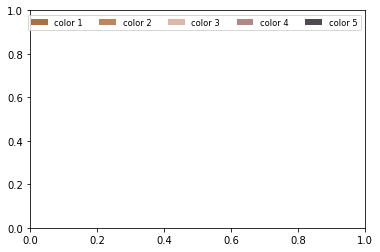

In [ ]:
def validate_colors(number_ofcol, arrayOfinput):
  arr = []
  for i in range(number_ofcol):
    arr.append(arrayOfinput[i].tolist())
  
  for j in range(5-len(arr)):
    if (len(arr)<5):
       arr.append("N")

  resultCol = query(arr).json().get("result")
  return resultCol
arr = validate_colors(2,arr_ofcolors[1:])
print(arr)
generate_patches(arr)


[array([173.98058252, 110.69711473,  72.80869684]), array([186.17096059, 134.96553489,  97.45879543])]


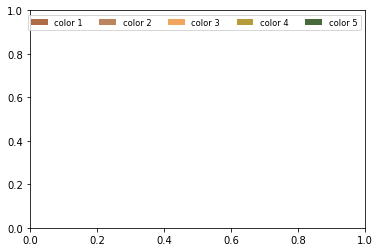

149.0
11 149 173
57
122.0
12 122 186
96


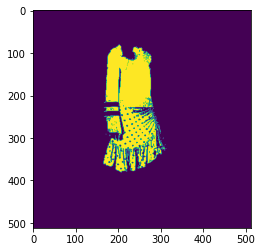

In [ ]:
# 3 value of input color is hsv
import random
col = 2
input_color = arr_ofcolors[1:col+1]
print(input_color)
target_color = validate_colors(col,input_color)
generate_patches(target_color)
random.shuffle(target_color)
changeColor("new.png",input_color,target_color,40)

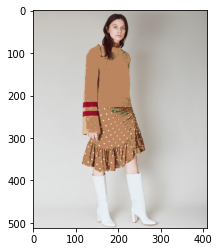

In [ ]:

remove_bk("result.png")
combine(path_img,"result.png")


# Test the UNEt architecture 

In [ ]:
import tqdm
import os
import random
import matplotlib.image as mpimg


number_ofim = 30
path = "/content/drive/MyDrive/Colab Notebooks/datasets/pictures_outfit/bauman"
def generate_photos(path):
  for i in tqdm.tqdm(range(1,number_ofim+1)):
      file = random.choice(os.listdir(path))
      image_path = os.path.join(path,file)
      #img = mpimg.imread(image_path)
    
      
      original = cv2.imread(image_path)
      original = cv2.resize(original,(224,224))
      images_original.append(original)
    

      takeperson(image_path)[1]
      body = cv2.imread("noback.png")
      image2 =  get_cloth("noback.png",False)
      cv2.imwrite("out.png",image2)
      removeAlpha("out.png")
      dress = cv2.imread("new.png")
      
      os_path = "/content/drive"
      datadir = os.path.join(os_path,"MyDrive","datasetTemp")
      drive.mount(os_path)
      cv2.imwrite(os.path.join(datadir,"body"+str(i)+".png"),body)
      cv2.imwrite(os.path.join(datadir,"dress"+str(i)+".png"),dress)
      cv2.imwrite(os.path.join(datadir,"original"+str(i)+".png"),original)


In [ ]:
import pickle
def testUnet(pathOf):
  UNET = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/datasets/unet.h5')
  with open("/content/drive/MyDrive/datasetTemp/meanArrpixels.pkl",'rb') as file:
    mean = pickle.load(file)
  plt.figure(figsize=(16,8))
  img = cv2.imread(pathOf)
  plt.subplot(1,3,1)
  plt.imshow(cv2.cvtColor(cv2.resize(img.copy(),(224,224)), cv2.COLOR_BGRA2RGB))


  mask_test, test = takeperson(pathOf)
  test = cv2.resize(test,(224,224))
  test = test - mean.reshape(-1,224,224,3)
  pred = UNET.predict(test.astype('float64'))[0]
  plt.subplot(1,3,2)
  plt.imshow(pred)

  pred_dress = pred.copy()[:,:,1]
  pred_dress[pred_dress>=0.90]=1
  pred_dress[pred_dress<0.90]=0
  dress = (cv2.resize(img.copy(),(224,224))*pred_dress[:,:,np.newaxis]).astype('int')
  dress[pred_dress == 0] = (255, 255, 255)
  plt.subplot(1,3,3)
  plt.imshow(cv2.cvtColor(dress.astype('uint8'), cv2.COLOR_BGRA2RGB))


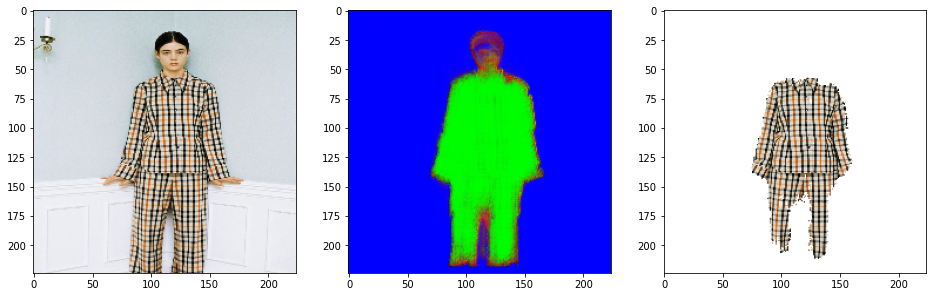

In [ ]:
testUnet("/content/drive/MyDrive/datasetTemp/original2/original18.png")